## Imports

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import bilby

%pylab inline
%matplotlib inline

from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design

Populating the interactive namespace from numpy and matplotlib


### Downoading Open Source gravitational wave data 

In [2]:
interferometers = bilby.gw.detector.networks.InterferometerList(["H1", "L1", "V1"])

trigger_time = bilby.gw.utils.get_event_time("170814")
start_time = trigger_time - 3
duration = 4
end_time = start_time + duration
roll_off = 0.2

Getting analysis data from H1


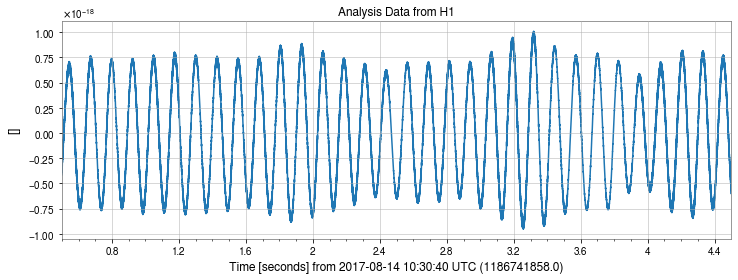

Getting analysis data from L1


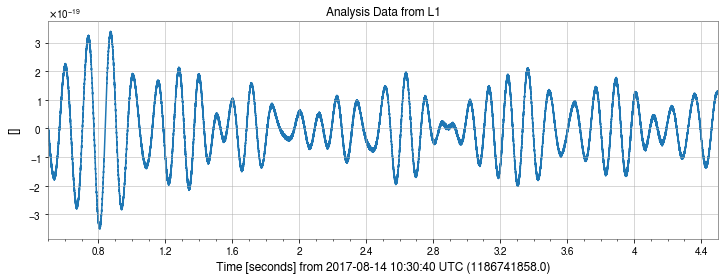

Getting analysis data from V1


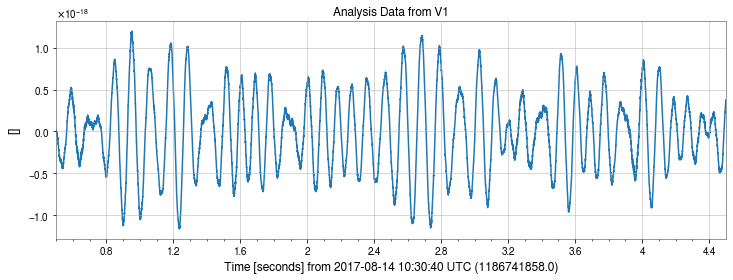

In [3]:
for interferometer in interferometers:
    print("Getting analysis data from {}".format(interferometer.name))
    analysis_data = TimeSeries.fetch_open_data(interferometer.name, start_time, end_time)
    
    analysis_data.plot()
    plt.title("Analysis Data from {}".format(interferometer.name))
    plt.show()
    
    interferometer.strain_data.roll_off = roll_off
    interferometer.strain_data.set_from_gwpy_timeseries(analysis_data)

In [4]:
dir(interferometer.strain_data)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_channel',
 '_frequency_domain_strain',
 '_frequency_mask',
 '_frequency_mask_updated',
 '_infer_dependence',
 '_infer_frequency_domain_dependence',
 '_infer_time_domain_dependence',
 '_maximum_frequency',
 '_minimum_frequency',
 '_time_domain_strain',
 '_times_and_frequencies',
 'alpha',
 'channel',
 'create_power_spectral_density',
 'duration',
 'frequency_array',
 'frequency_domain_strain',
 'frequency_mask',
 'low_pass_filter',
 'maximum_frequency',
 'minimum_frequency',
 'roll_off',
 'sampling_frequency',
 'set_from_channel_name',
 'set_from_csv',
 'set_from_frame_file',
 'set_from_frequency_domain_strain',
 'set_fr

## Power Spectral Density

Information about window function can be found <a href = "https://www.wikiwand.com/en/Window_function#Adjustable_windows">here</a>.

In [5]:
psd_start_time = start_time + duration
psd_duration = duration * 32
psd_end_time = psd_start_time + psd_duration
psd_tukey_alpha = 2 * roll_off/duration
overlap = duration/2

Getting PSD data from H1


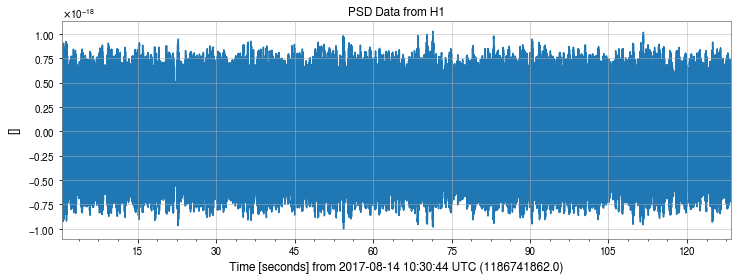

Getting PSD data from L1


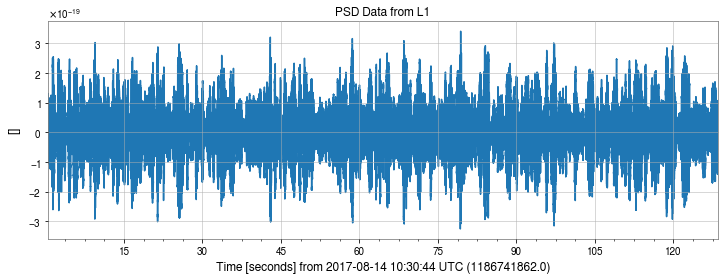

Getting PSD data from V1


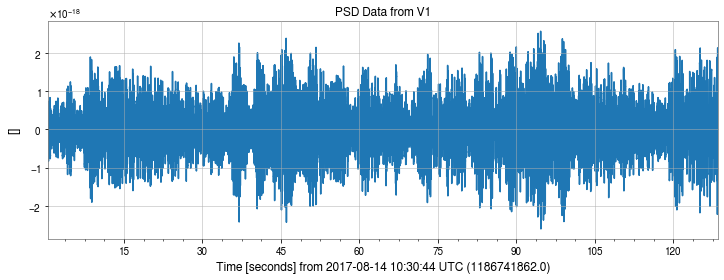

In [6]:
for interferometer in interferometers:
    print("Getting PSD data from {}".format(interferometer.name))
    psd_data = TimeSeries.fetch_open_data(interferometer.name, psd_start_time, psd_end_time)
    
    psd_data.plot()
    plt.title("PSD Data from {}".format(interferometer.name))
    plt.show()
    
    psd = psd_data.psd(fftlength = duration, overlap = overlap, 
                       window = ("tukey", psd_tukey_alpha), method ="median")
    
    interferometer.power_spectral_density = bilby.gw.detector.psd.PowerSpectralDensity(
        frequency_array = psd.frequencies.value, psd_array = psd.value)

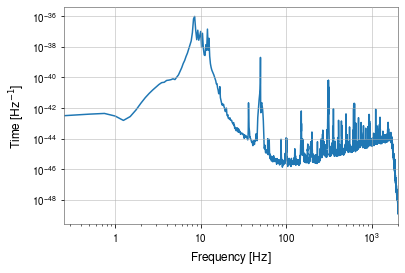

In [7]:
psd.plot()
plt.show()

In [8]:
dir(interferometer.power_spectral_density)

['_PowerSpectralDensity__asd_array',
 '_PowerSpectralDensity__check_file_was_asd_file',
 '_PowerSpectralDensity__check_file_was_psd_file',
 '_PowerSpectralDensity__check_frequency_array_matches_density_array',
 '_PowerSpectralDensity__import_amplitude_spectral_density',
 '_PowerSpectralDensity__import_power_spectral_density',
 '_PowerSpectralDensity__interpolate_power_spectral_density',
 '_PowerSpectralDensity__power_spectral_density_interpolated',
 '_PowerSpectralDensity__psd_array',
 '_PowerSpectralDensity__validate_file_name',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_asd_file',
 '_cache',
 '_psd_file',
 '_update_cache',
 'asd_array',
 'asd_file',
 'frequenc

02:43 bilby INFO    : Generating frequency domain strain from given time domain strain.
02:43 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


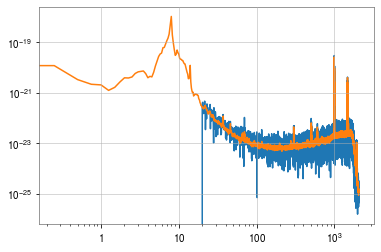

02:43 bilby INFO    : Generating frequency domain strain from given time domain strain.
02:43 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


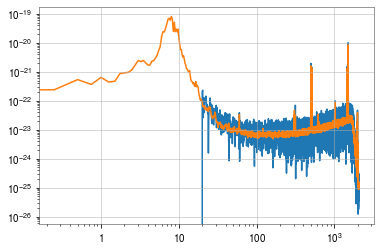

02:43 bilby INFO    : Generating frequency domain strain from given time domain strain.
02:43 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


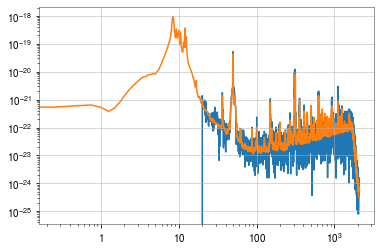

In [9]:
for interferometer in interferometers:
    plt.loglog(interferometer.frequency_array, abs(interferometer.frequency_domain_strain))
    plt.loglog(interferometer.frequency_array, abs(interferometer.amplitude_spectral_density_array))
    plt.show()
    plt.close()

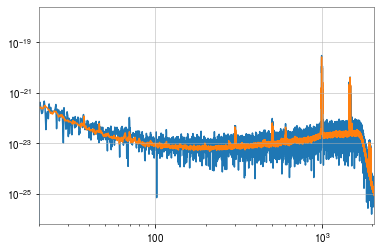

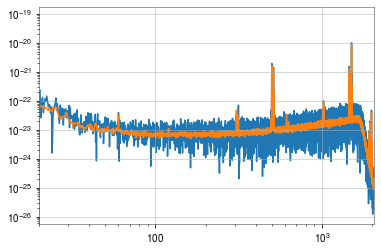

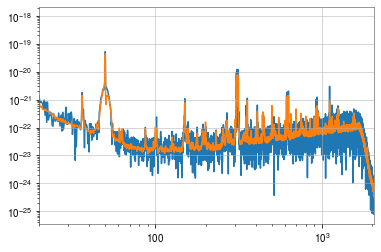

In [10]:
for interferometer in interferometers:
    plt.loglog(interferometer.frequency_array, abs(interferometer.frequency_domain_strain))
    plt.loglog(interferometer.frequency_array, abs(interferometer.amplitude_spectral_density_array))
    plt.xlim(interferometer.minimum_frequency, interferometer.maximum_frequency)
    plt.show()
    plt.close()

### Generating Waveform

In [11]:
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=20)

waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
                        duration = interferometers.duration,
                        sampling_frequency = interferometers.sampling_frequency,
                        frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
                        parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                        waveform_arguments = waveform_arguments)

02:44 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


### Creating a prior

In [12]:
priors = bilby.gw.prior.BBHPriorDict(aligned_spin = True)
priors['chirp_mass'] = bilby.core.prior.Uniform(name='chirp_mass', minimum=24.0, maximum=30.0,
                                              latex_label = "$\\mathcal{M}$", unit = "$\\mathcal{M}_{\\odot}$")
priors['mass_ratio'] = bilby.core.prior.Uniform(name='mass_ratio', minimum=0.4, maximum=1, 
                                               latex_label = "$q$")

del priors['mass_1'], priors['mass_2']

priors['geocent_time'] = bilby.core.prior.Uniform(name="geocent_time", minimum=trigger_time-0.1, 
                                                 maximum=trigger_time+0.1, latex_label = "$t_c$", unit = "$s$")

02:44 bilby INFO    : Using aligned spin prior
02:44 bilby INFO    : No prior given, using default BBH priors in /home/deepnika/anaconda3/lib/python3.8/site-packages/bilby/gw/prior_files/aligned_spins_bbh.prior.


In [13]:
for key in priors:
    print(f"{key}: {priors[key]}")

mass_ratio: Uniform(minimum=0.4, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
chirp_mass: Uniform(minimum=24.0, maximum=30.0, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$\\mathcal{M}_{\\odot}$', boundary=None)
luminosity_distance: UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None)
dec: Cosine(name='dec', latex_label='$\\mathrm{DEC}$', unit=None, minimum=-1.5707963267948966, maximum=1.5707963267948966, boundary=None)
ra: Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='periodic')
theta_jn: Sine(name='theta_jn', latex_label='$\\theta_{JN}$', unit=None, minimum=0, maximum=3.141592653589793, boundary=None)
psi: Uniform(minimum=0, maximum=3.141592653589793, name='psi', latex_

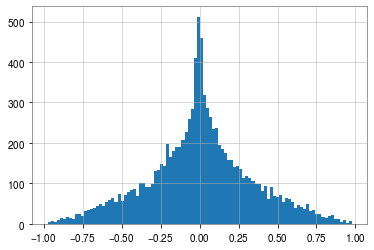

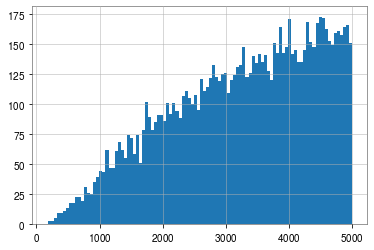

In [14]:
prior_samples = priors.sample(10000)

plt.hist(prior_samples["chi_1"], bins = 100)
plt.show()
plt.close()

plt.hist(prior_samples["luminosity_distance"], bins = 100)
plt.show()
plt.close()

In [15]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(interferometers = interferometers,
                                                            waveform_generator = waveform_generator, 
                                                            priors = priors, time_marginalization = False,
                                                            distance_marginalization = False,
                                                            phase_marginalization = True)

In [16]:
npoints = 50
sampler = 'dynesty'
result = bilby.run_sampler(
    likelihood,
    priors,
    outdir='outdir-GW170814',
    label='GW170814',
    sampler=sampler,
    npoints=npoints,
    use_ratio=False,
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters)

02:44 bilby INFO    : Running for label 'GW170814', output will be saved to 'outdir-GW170814'
02:44 bilby INFO    : Using LAL version Branch: None;Tag: lalsuite-v6.74;Id: b766e8591185f1b59ba22afed547bcf59c6842a7;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
02:44 bilby INFO    : Search parameters:
02:44 bilby INFO    :   mass_ratio = Uniform(minimum=0.4, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
02:44 bilby INFO    :   chirp_mass = Uniform(minimum=24.0, maximum=30.0, name='chirp_mass', latex_label='$\\mathcal{M}$', unit='$\\mathcal{M}_{\\odot}$', boundary=None)
02:44 bilby INFO    :   luminosity_distance = UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None)
02:44 bilby INFO    :   dec = Cosine(name='dec', lat

0it [00:00, ?it/s]

02:44 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 50, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 30, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fb2360862e0>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
02:44 bilby INFO    : Checkpoint every check_point_delta_t = 600s
02:44 bilby INFO    : Using dynesty version 1.0.1
02:44 bilby INFO    : Generating initial points from the prior

399it [10:14,  2.41s/it, bound:213 nc:184 ncall:4.7e+04 eff:0.9% logz=-24825.37+/-0.59 dlogz:53.932>0.1]

02:55 bilby INFO    : Written checkpoint file outdir-GW170814/GW170814_resume.pickle
/home/deepnika/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


765it [20:23,  1.95s/it, bound:583 nc:111 ncall:9.2e+04 eff:0.8% logz=-24747.99+/-0.79 dlogz:16.053>0.1]

03:05 bilby INFO    : Written checkpoint file outdir-GW170814/GW170814_resume.pickle
/home/deepnika/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


1198it [30:32,  1.43s/it, bound:1022 nc:101 ncall:1.4e+05 eff:0.9% logz=-24729.85+/-0.91 dlogz:1.255>0.1]

03:15 bilby INFO    : Written checkpoint file outdir-GW170814/GW170814_resume.pickle
/home/deepnika/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


1371it [34:36,  1.29s/it, bound:1196 nc:101 ncall:1.5e+05 eff:0.9% logz=-24729.29+/-0.92 dlogz:0.101>0.1]

03:19 bilby INFO    : Written checkpoint file outdir-GW170814/GW170814_resume.pickle
03:19 bilby INFO    : Writing 260 current samples to outdir-GW170814/GW170814_samples.dat
/home/deepnika/anaconda3/lib/python3.8/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


1371it [34:38,  1.52s/it, bound:1196 nc:  1 ncall:1.5e+05 eff:0.9% logz=-24729.24+/-0.93 dlogz:0.002>0.1]

03:19 bilby INFO    : Sampling time: 0:34:35.013414
03:19 bilby INFO    : Reconstructing marginalised parameters.




100%|██████████| 1421/1421 [00:11<00:00, 128.88it/s]

03:19 bilby INFO    : Generating sky frame parameters.



100%|██████████| 1421/1421 [00:00<00:00, 2219.90it/s]


03:19 bilby INFO    : Computing SNRs for every sample.


100%|██████████| 1421/1421 [00:20<00:00, 68.66it/s]


03:20 bilby INFO    : Summary of results:
nsamples: 1421
ln_noise_evidence: -24870.652
ln_evidence: -24729.238 +/-  0.934
ln_bayes_factor: 141.414 +/-  0.934



findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


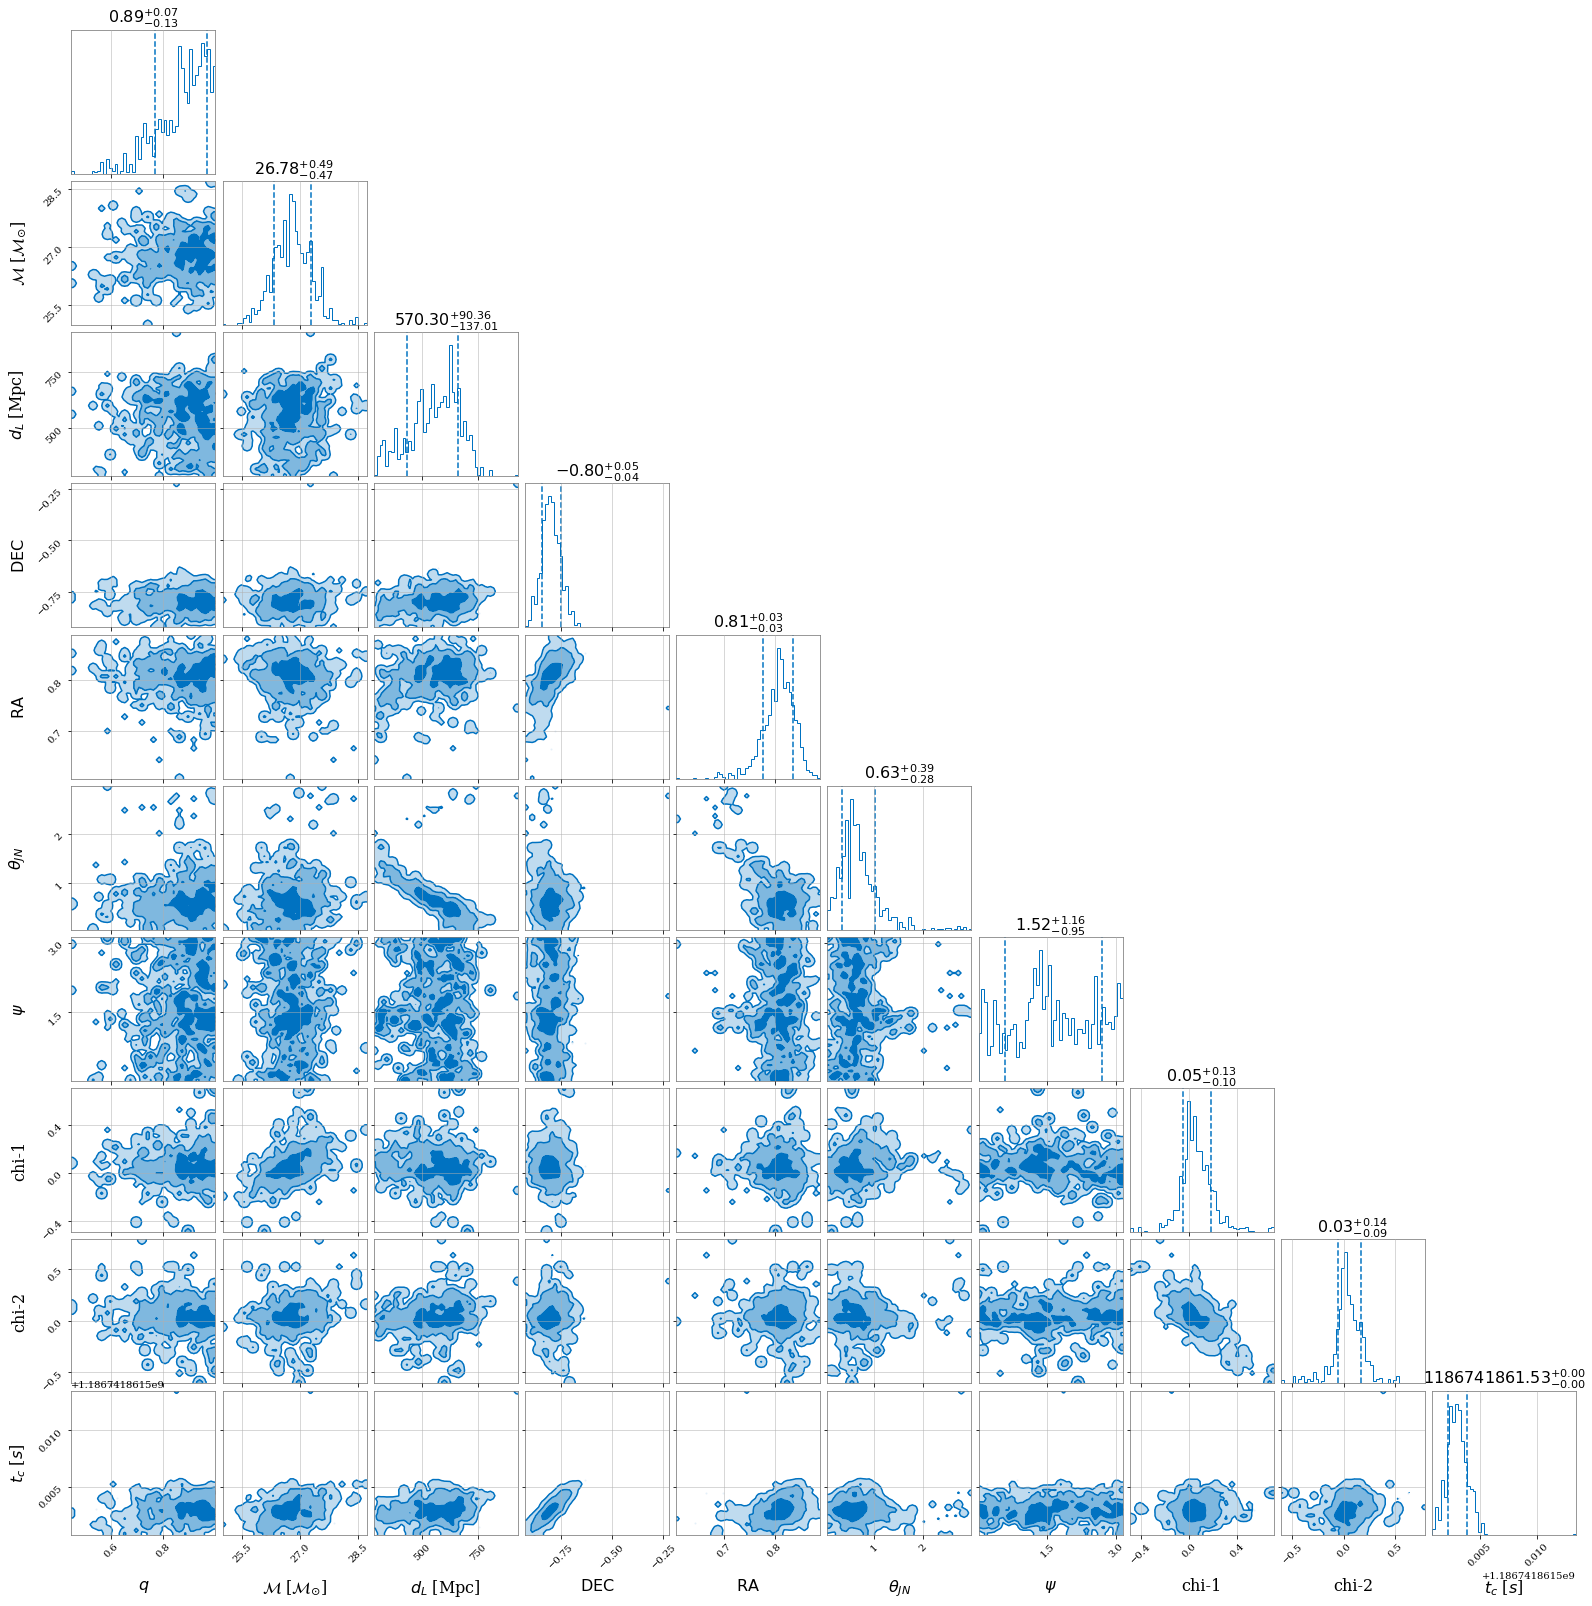

In [18]:
result.plot_corner()

In [19]:
result.posterior

,mass_ratio,chirp_mass,luminosity_distance,dec,ra,theta_jn,psi,chi_1,chi_2,geocent_time,...,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,H1_matched_filter_snr,H1_optimal_snr,L1_matched_filter_snr,L1_optimal_snr,V1_matched_filter_snr,V1_optimal_snr
0,0.861504,26.750353,435.794590,-0.891716,0.605080,2.320130,2.974155,0.162571,-0.001219,1.186742e+09,...,30.329195,26.128711,24.493022,56.457906,9.453916-0.127798j,10.735496,14.374769+2.985377j,15.100642,3.686822+2.021159j,5.693352
1,0.846471,27.244281,928.456638,-0.223084,0.745141,2.758824,1.832836,-0.156018,0.368188,1.186742e+09,...,28.720324,24.310919,22.987305,53.031243,9.306733+2.793573j,7.737872,14.733849+1.510667j,15.148905,2.962541+0.696420j,1.621100
2,0.678568,26.640807,668.469070,-0.722781,0.786361,0.666411,1.055451,0.176500,-0.044921,1.186742e+09,...,32.787751,22.248702,23.425006,55.036454,9.847292-0.890983j,8.299081,14.663481-0.639982j,12.649475,3.283365+2.953636j,2.903861
3,0.920462,27.188791,723.180820,-0.698177,0.812407,0.564314,2.612882,0.158704,0.005051,1.186742e+09,...,28.372029,26.115371,23.692601,54.487400,9.901758-0.623059j,8.433149,14.552433-0.563878j,12.981124,3.603418+2.663124j,2.764209
4,0.858638,26.770467,573.979164,-0.633009,0.854599,0.904449,0.839404,0.058846,0.030564,1.186742e+09,...,29.667821,25.473912,23.918432,55.141734,9.981972+0.096257j,8.217854,14.486213-2.273426j,12.666267,4.117692+1.711087j,2.099828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1416,0.964461,26.767787,586.071314,-0.819912,0.799810,0.592038,0.115740,0.063459,0.003834,1.186742e+09,...,27.916710,26.924576,23.866368,54.841286,9.916549-1.264884j,9.927653,14.849471-0.878400j,14.288993,4.435787+0.063591j,4.002648
1417,0.964461,26.767787,586.071314,-0.819912,0.799810,0.592038,0.115740,0.063459,0.003834,1.186742e+09,...,27.916710,26.924576,23.866368,54.841286,9.996313+0.107727j,9.927653,14.829550+1.167402j,14.288993,4.385108+0.671623j,4.002648
1418,0.944148,26.701626,381.723916,-0.817710,0.791021,1.057060,1.510560,-0.009183,0.082996,1.186742e+09,...,29.194736,27.564163,24.693510,56.758900,9.925761-1.213486j,10.147453,14.846383-1.009394j,15.660090,4.457156+0.184202j,4.521711
1419,0.944148,26.701626,381.723916,-0.817710,0.791021,1.057060,1.510560,-0.009183,0.082996,1.186742e+09,...,29.194736,27.564163,24.693510,56.758900,9.967423-0.802351j,10.147453,14.875411-0.395130j,15.660090,4.445739+0.368199j,4.521711


In [20]:
result.posterior["chirp_mass"]

0       26.750353
1       27.244281
2       26.640807
3       27.188791
4       26.770467
          ...    
1416    26.767787
1417    26.767787
1418    26.701626
1419    26.701626
1420    26.701626
Name: chirp_mass, Length: 1421, dtype: float64

In [21]:
Mc = result.posterior['chirp_mass'].values
lower_bound = np.quantile(Mc, 0.05)
upper_bound = np.quantile(Mc, 0.95)
median = np.quantile(Mc, 0.5)
print('Mc = {} with 90% confidence interval from {} to {}'.format(median, lower_bound, upper_bound))

Mc = 26.781783969845645 with 90% confidence interval from 25.987915202508944 to 27.573972322642515


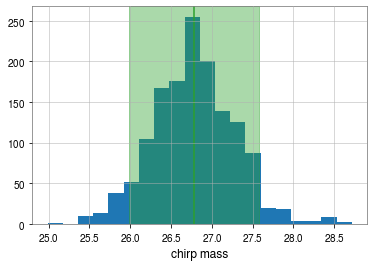

In [24]:
fig, ax = plt.subplots()
ax.hist(result.posterior["chirp_mass"], bins=20)
ax.axvspan(lower_bound, upper_bound, color='C2', alpha=0.4)
ax.axvline(median, color='C2')
ax.set_xlabel("chirp mass")
plt.show()

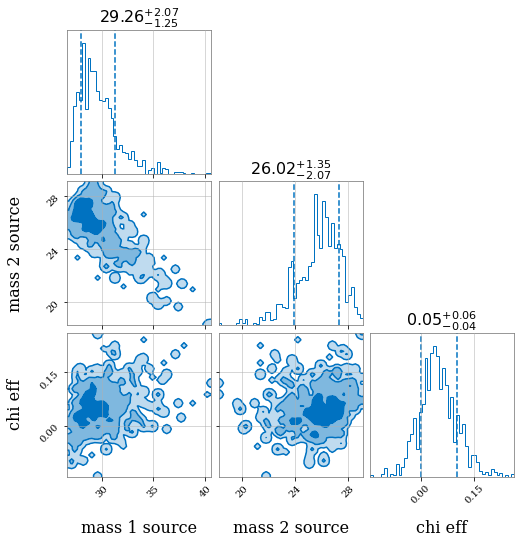

In [25]:
result.plot_corner(parameters = ["mass_1_source", "mass_2_source", "chi_eff"])

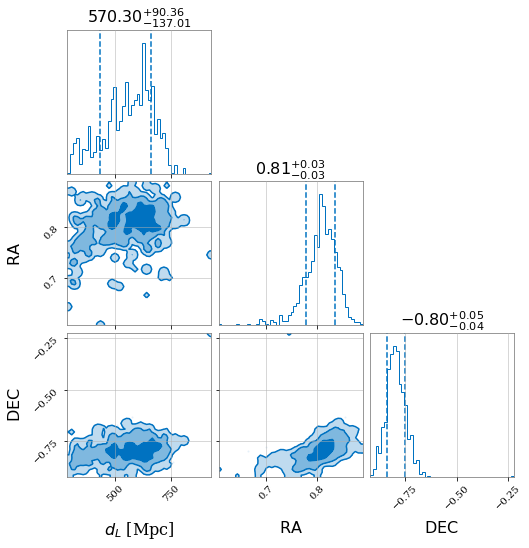

In [26]:
result.plot_corner(parameters=["luminosity_distance", "ra", "dec"])

In [27]:
print("ln Bayes factor = {} +/- {}".format(result.log_bayes_factor, result.log_evidence_err))

ln Bayes factor = 141.41431634617038 +/- 0.9341632255632781
